# L-Layer Neural Network

Using numpy for vectorizing the calculus, this notebook will permit to construct, train and use a L-Layer Neural network, using different activation functions and different layer sizes.

Will focus here on a **logisitic regression** for the output. The Neural Network will look like this:

<img src="images/NN.png">

For one example $x^{(i)}$:
$$for\,l \in [1,\,4],\; z^{[l](i)} = {w^{[l]}}^T a^{[l-1](i)} + b^{[l]} \tag{1}$$
$$for\,l \in [1,\,3],\;a^{[l](i)} = ReLU(z^{[l](i)})\tag{2.1}$$
$$a^{[4](i)} = \sigma(z^{[4](i)})\tag{2.2}$$

With:
$$a^{[0](i)} = x^{(i)} \tag{3}$$
$$a^{[4](i)} = \hat{y}^{(i)} \tag{4}$$

$$\mathcal{L}(\hat{y}^{(i)}, y^{(i)}) =  - y^{(i)}  \log(\hat{y}^{(i)}) - (1-y^{(i)} )  \log(1-\hat{y}^{(i)})\tag{5}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{[l](i)}, y^{(i)})\tag{6}$$

## What to do?

At the end of this notebook, we'll start again the cat example using another architecture than the basic shallow NN.

## Organization of this Notebook 
    1. Packages
    2. Activation functions
    3. Initialization of the parameters
    4. Forward and backward propagation
    5. Predict methods and Model construction
    6. Try on cat images
    7. Try the model decision

## 1 - Packages ##

- [numpy](www.numpy.org): the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org): a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org): a famous library to plot graphs in Python.

In [21]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from py_utils import load_dataset # Copy/pasted loader

%matplotlib inline

## 2 - Activation functions ##

Several activation functions can be use here:
$$sigmoid(z) = \frac{1}{1 + e^{-z}}\tag{7}$$

$$tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}\tag{8}$$

$$ReLU(z) = max(0, \,z)\tag{9}$$

$$LReLU(z) = max(0.01z, \,z)\tag{10}$$

The derivatives are then:
$$\frac{d\,sigmoid(z)}{d\,z} = sigmoid(z)\,(1 - sigmoid(z))\tag{11}$$

$$\frac{d\,tanh(z)}{d\,z} = 1 - tanh^{2}(z)\tag{12}$$

$$\frac{d\,ReLU(z)}{d\,z} = \begin{cases} 0 & \mbox{if } z < 0 \\ 1 & \mbox{otherwise } \end{cases}\tag{13}$$

$$\frac{d\,LReLU(z)}{d\,z} = \begin{cases} 0.01 & \mbox{if } z < 0 \\ 1 & \mbox{otherwise } \end{cases}\tag{14}$$

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return np.tanh(z)

def ReLU(z):
    return np.maximum(z,0)

def LReLU(z):
    return np.maximum(z,0.01*z)

In [3]:
def d_sigmoid(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def d_tanh(Z):
    return 1 - np.power(np.tanh(Z), 2)

def d_ReLU(Z):
    dZ = np.array(Z, copy=True)
    dZ[dZ <= 0] = 0
    dZ[dZ > 0] = 1
    
    assert (dZ.shape == Z.shape)
    return dZ

def d_LReLU(Z):
    dZ = np.array(Z, copy=True)
    dZ[dZ > 0] = 1
    dZ[dZ <= 0] = 0.01 * dZ[dZ <= 0]
    
    assert (dZ.shape == Z.shape)
    return dZ

## 3 - Initialization of the parameters ##

As a reminder, the matrices dimension are:

$$W^{[l]}.shape = (n_{h_l},\,n_{h_{l-1}})\tag{15}$$
$$b^{[l]}.shape = (n_{h_l},\,1)\tag{16}$$

In [4]:
def displayDimensions(parameters):
    L = len(parameters) // 3
    print("number of Layers: %i"%(L))
    
    for l in range(L):
        print("  %i / W(%i, %i) / b(%i, %i) / %s" %(l+1, parameters['W' + str(l+1)].shape[0], parameters['W' + str(l+1)].shape[1], parameters['b' + str(l+1)].shape[0], parameters['b' + str(l+1)].shape[1], parameters['F' + str(l+1)]))
    print("")

In [5]:
def initialize(nbNeurons, actFunctions):
    assert(len(nbNeurons) == len(actFunctions) + 1)
    parameters = {}
    
    for l in range(1, len(nbNeurons)):
        parameters['W' + str(l)] = np.random.randn(nbNeurons[l], nbNeurons[l-1]) * np.sqrt( 2 / nbNeurons[l-1])
        parameters['b' + str(l)] = np.zeros((nbNeurons[l], 1))
        
        assert(parameters['W' + str(l)].shape == (nbNeurons[l], nbNeurons[l-1]))
        assert(parameters['b' + str(l)].shape == (nbNeurons[l], 1))
        
        parameters['F' + str(l)] = actFunctions[l-1]
    
    displayDimensions(parameters)
    
    return parameters

## 4 - Forward and backward propagation ##

Forward Propagation:
$$Z^{[l]} =  W^{[l]} \; A^{[l-1]} + b^{[l]}\tag{17}$$

$$A^{[l]} = g^{[l]}(Z^{[l]})\tag{18}$$


In [6]:
def forwardPropagation(W, b, previousA, actFunction):
    Z = np.dot(W, previousA) + b
    
    assert(Z.shape == (W.shape[0], previousA.shape[1]))
    
    if actFunction == "sigmoid":
        A = sigmoid(Z)
    elif actFunction == "tanh":
        A = tanh(Z)
    elif actFunction == "ReLU":
        A = ReLU(Z)
    elif actFunction =="LReLU":
        A = LReLU(Z)
    
    assert (A.shape == Z.shape)
    return Z, A

In [7]:
def globalForwardPropagation(X, parameters):
    Zs = []
    As = [X]
    A = X
    L = len(parameters) // 3
    
    for l in range(1, L+1):
        A_prev = A
        Z, A = forwardPropagation(parameters['W'+str(l)], parameters['b'+str(l)], A_prev, parameters['F'+str(l)])
        Zs = Zs + [Z]
        As = As + [A]
    
    return Zs, As, A

Backward Propagation:
$$\frac{\partial \mathcal{L}}{\partial Z^{[l]}} = \frac{\partial \mathcal{L}}{\partial A^{[l]}} \frac{\partial A^{[l]}}{\partial Z^{[l]}} = dA^{[l]} \; {g^{[l]}}'(Z^{[l]})\tag{19}$$

$$\frac{\partial \mathcal{L}}{\partial W^{[l]}} = \frac{\partial \mathcal{L}}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial W^{[l]}} = dZ^{[l]} \; A^{[l-1]}\tag{20}$$

$$\frac{\partial \mathcal{L}}{\partial b^{[l]}} = \frac{\partial \mathcal{L}}{\partial Z^{[l]}} \frac{\partial b^{[l]}}{\partial b^{[l]}} = dZ^{[l]}\tag{21}$$

$$\frac{\partial \mathcal{L}}{\partial A^{[l-1]}} = \frac{\partial \mathcal{L}}{\partial Z^{[l]}} \frac{\partial Z^{[l]}}{\partial A^{[l-1]}} = W^{[l]} \; dZ^{[l]}\tag{22}$$

In [8]:
def backwardPropagation(W_l, Z_l, dA_l, A_l1, actFunction):
    
    if actFunction == "sigmoid":
        dZ_l = dA_l * d_sigmoid(Z_l)
    elif actFunction == "tanh":
        dZ_l = dA_l * d_tanh(Z_l)
    elif actFunction == "ReLU":
        dZ_l = dA_l * d_ReLU(Z_l)
    elif actFunction == "LReLU":
        dZ_l = dA_l * d_LReLU(Z_l)
    
    dW_l = np.dot(dZ_l, A_l1.T) / A_l1.shape[1]
    db_l = np.sum(dZ_l, axis = 1, keepdims = True) / A_l1.shape[1]
    dA_l1 = np.dot(W_l.T, dZ_l)
    
    assert(dA_l1.shape == A_l1.shape)
    assert(dW_l.shape == W_l.shape)
    
    return dA_l1, dW_l, db_l
    

In [9]:
def globalBackwardPropagation(Y, Zs, As, parameters):
    grads = {}
    L = len(Zs)
    
    # Zs from 1 to L and As from 0 to L
    assert(len(Zs) + 1 == len(As))
    
    # Initializing the backpropagation
    AL = As[L]
    Y = Y.reshape((AL.shape))
    dA_l1 = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    assert(dA_l1.shape == AL.shape)
     
    # From l=L-1 to l=0, outbox included
    for l in reversed(range(L)):
        dA_l1, dW_l, dB_l = backwardPropagation(parameters["W" + str(l+1)], Zs[l], dA_l1, As[l], parameters["F" + str(l+1)])
        grads["dW" + str(l + 1)] = dW_l
        grads["db" + str(l + 1)] = dB_l

    return grads

For all parameters:

$$W^{[l]} = W^{[l]} - \alpha \, \frac{\partial \mathcal{L}}{\partial W^{[l]}}\tag{23}$$

$$b^{[l]} = b^{[l]} - \alpha \, \frac{\partial \mathcal{L}}{\partial b^{[l]}}\tag{24}$$

In [10]:
def updateParameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 3
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

The cost is obtained by the calculus:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{6}$$

In [11]:
def computeCost(AL, Y):
    
    cost = -np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / Y.shape[1]
    
    return np.squeeze(cost)

## 5 - Predict methods and Model construction ##


As for the prediction, it is basically just a forward propagation followed by a prediction:

<img src="images/predictProcess.png" style="height:100px;">

With:
$$Y_{prediction} = \begin{cases} 1 & \mbox{if } \hat{Y} > decision_{treshold} \\ 0 & \mbox{otherwise } \end{cases}\tag{25}$$

In [12]:
def predict(parameters, X, decision_treshold = 0.5):
    _, _, A = globalForwardPropagation(X, parameters)

    P = (A > decision_treshold)
    
    return P

As for the training, an iteration of forward and backward propagation will occur. In order to compute the derivatives during the backpropagation process, we then need to store the required variable during the forward propagation process:

<img src="images/trainProcess.png" style="height:300px;">


With:
$$\mathcal{L}(A^{[L]}, Y) =  - Y \log(A^{[L]}) - (1 - Y ) \log(1-A^{[L]})\tag{5}$$

And:
$$ \frac{\partial \mathcal{L}}{\partial A^{[L]}} = - \; (\frac{Y}{A^{[L]}} - \frac{1 - Y}{1 - A^{[L]}})\tag{25}$$

We can now compute each gradients iteratively

In [13]:
def model(X, Y, X_test, Y_test, layers_dims, actFunctions, learning_rate = 0.0008, num_iterations = 5000, print_cost = False):
    # Initialize the weights and the bias
    parameters = initialize(layers_dims, actFunctions)
    
    costs = []
    
    for i in range(0, num_iterations):

        Zs, As, AL = globalForwardPropagation(X, parameters)
        
        epoch_cost = computeCost(AL, Y)
        
        grads = globalBackwardPropagation(Y, Zs, As, parameters)
        
        parameters = updateParameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost:
            if i % 100 == 0:
                print ("Cost after epoch %i: %f" %(i, epoch_cost))
            if i % 5:
                costs.append(epoch_cost)
    
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    # Test the model
    Y_prediction = predict(parameters, X)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - Y)) * 100))
    
    Y_prediction_test = predict(parameters, X_test)
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    return parameters

## 6 - Try on cat images ##

In [14]:
training_imgLoaded, training_label, testing_imgLoaded, testing_label, classes = load_dataset()

Here, we reshape and normalize the images to have a $(height*width*3 \text{ x } 1)$ matrix with pixels values between $0$ and $1$.

In [15]:
training_img = training_imgLoaded.reshape(training_imgLoaded.shape[0], -1).T / 255.
testing_img = testing_imgLoaded.reshape(testing_imgLoaded.shape[0], -1).T / 255.

In [16]:
print("Number of pixels: %i" %(training_img.shape[0]))
print("Number of training data: %i" %(training_img.shape[1]))

Number of pixels: 12288
Number of training data: 209


Here, we choose the dimensions of each layers and the activation functions:

In [17]:
layerDims = [12288, 20, 7, 5, 1]
actFunctions =  ["ReLU", "ReLU", "ReLU", "sigmoid"]

number of Layers: 4
  1 / W(20, 12288) / b(20, 1) / ReLU
  2 / W(7, 20) / b(7, 1) / ReLU
  3 / W(5, 7) / b(5, 1) / ReLU
  4 / W(1, 5) / b(1, 1) / sigmoid

Cost after epoch 0: 0.693253
Cost after epoch 100: 0.619828
Cost after epoch 200: 0.583731
Cost after epoch 300: 0.541043
Cost after epoch 400: 0.502448
Cost after epoch 500: 0.470140
Cost after epoch 600: 0.441822
Cost after epoch 700: 0.418682
Cost after epoch 800: 0.391378
Cost after epoch 900: 0.376341
Cost after epoch 1000: 0.352378
Cost after epoch 1100: 0.335048
Cost after epoch 1200: 0.320398
Cost after epoch 1300: 0.303730
Cost after epoch 1400: 0.285485
Cost after epoch 1500: 0.263829
Cost after epoch 1600: 0.241169
Cost after epoch 1700: 0.228004
Cost after epoch 1800: 0.208497
Cost after epoch 1900: 0.189343
Cost after epoch 2000: 0.183608
Cost after epoch 2100: 0.165291
Cost after epoch 2200: 0.150061
Cost after epoch 2300: 0.140307
Cost after epoch 2400: 0.129117
Cost after epoch 2500: 0.120725
Cost after epoch 2600: 0.

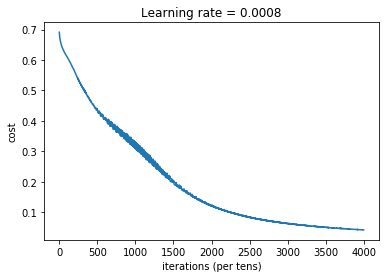

train accuracy: 99.04306220095694 %
test accuracy: 76.0 %


In [18]:
parameters = model(training_img, training_label, testing_img, testing_label, layerDims, actFunctions, print_cost = True)

In [19]:
def saveParameters(parameters):
    path = "parameters/"
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    for l in range(len(parameters) // 3):
        np.save(path + 'W' + str(l+1), parameters['W' + str(l+1)])
        np.save(path + 'b' + str(l+1), parameters['b' + str(l+1)])

In [22]:
saveParameters(parameters)

## 7. Try the model decision ##

Randomly pick 15 images in the dataset and display the image with the predicted classification.

In [23]:
def try_decision(parameters, X, Y):

    X_prep = X.reshape(X.shape[0], -1).T / 255.
    prediction = predict(parameters, X_prep)
    print("Accuracy: "  + str(np.sum( (prediction == Y) / X_prep.shape[1] )))
    
    indexes = np.random.randint(prediction.shape[1], size = 15)
    
    plt.figure(figsize=(20, 32))
    for i, index in enumerate(indexes):
        plt.subplot(6, 3, i+1)
        
        if (prediction[0][index]):
            plt.title("YES: Cat picture.")
        else:
            plt.title("NO: Non-cat picture.")
        plt.imshow(X[index])

TRAINING SET:
Accuracy: 0.9904306220095691


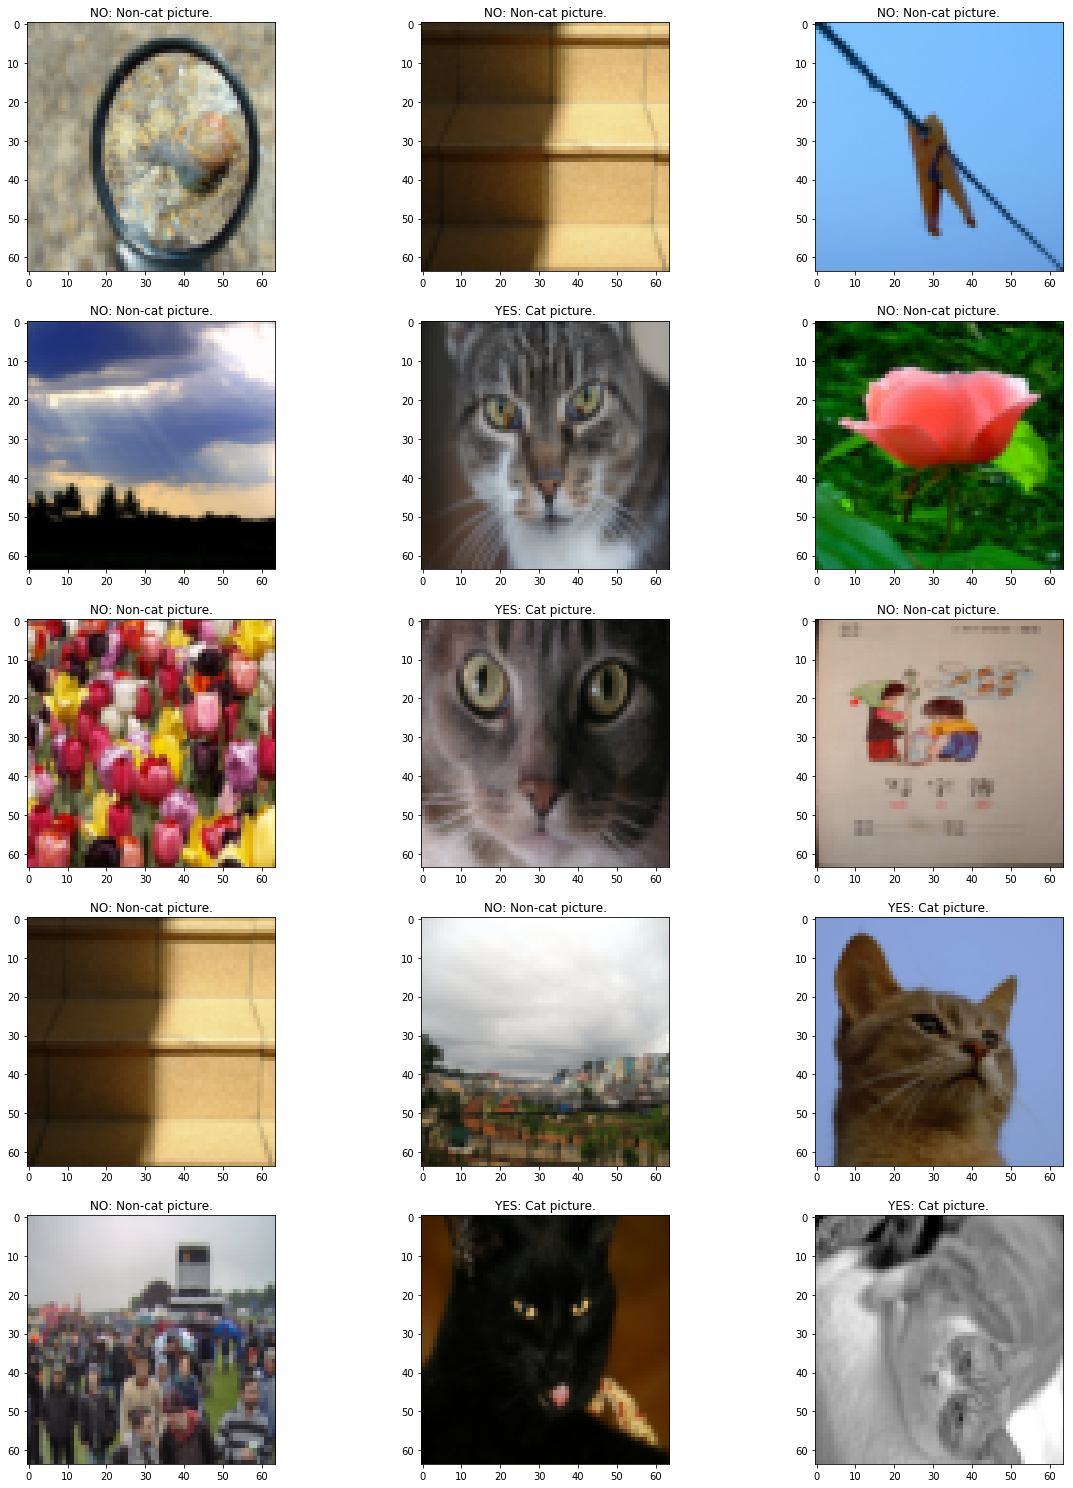

In [24]:
print("TRAINING SET:")
try_decision(parameters, training_imgLoaded, training_label)

TESTING SET:
Accuracy: 0.76


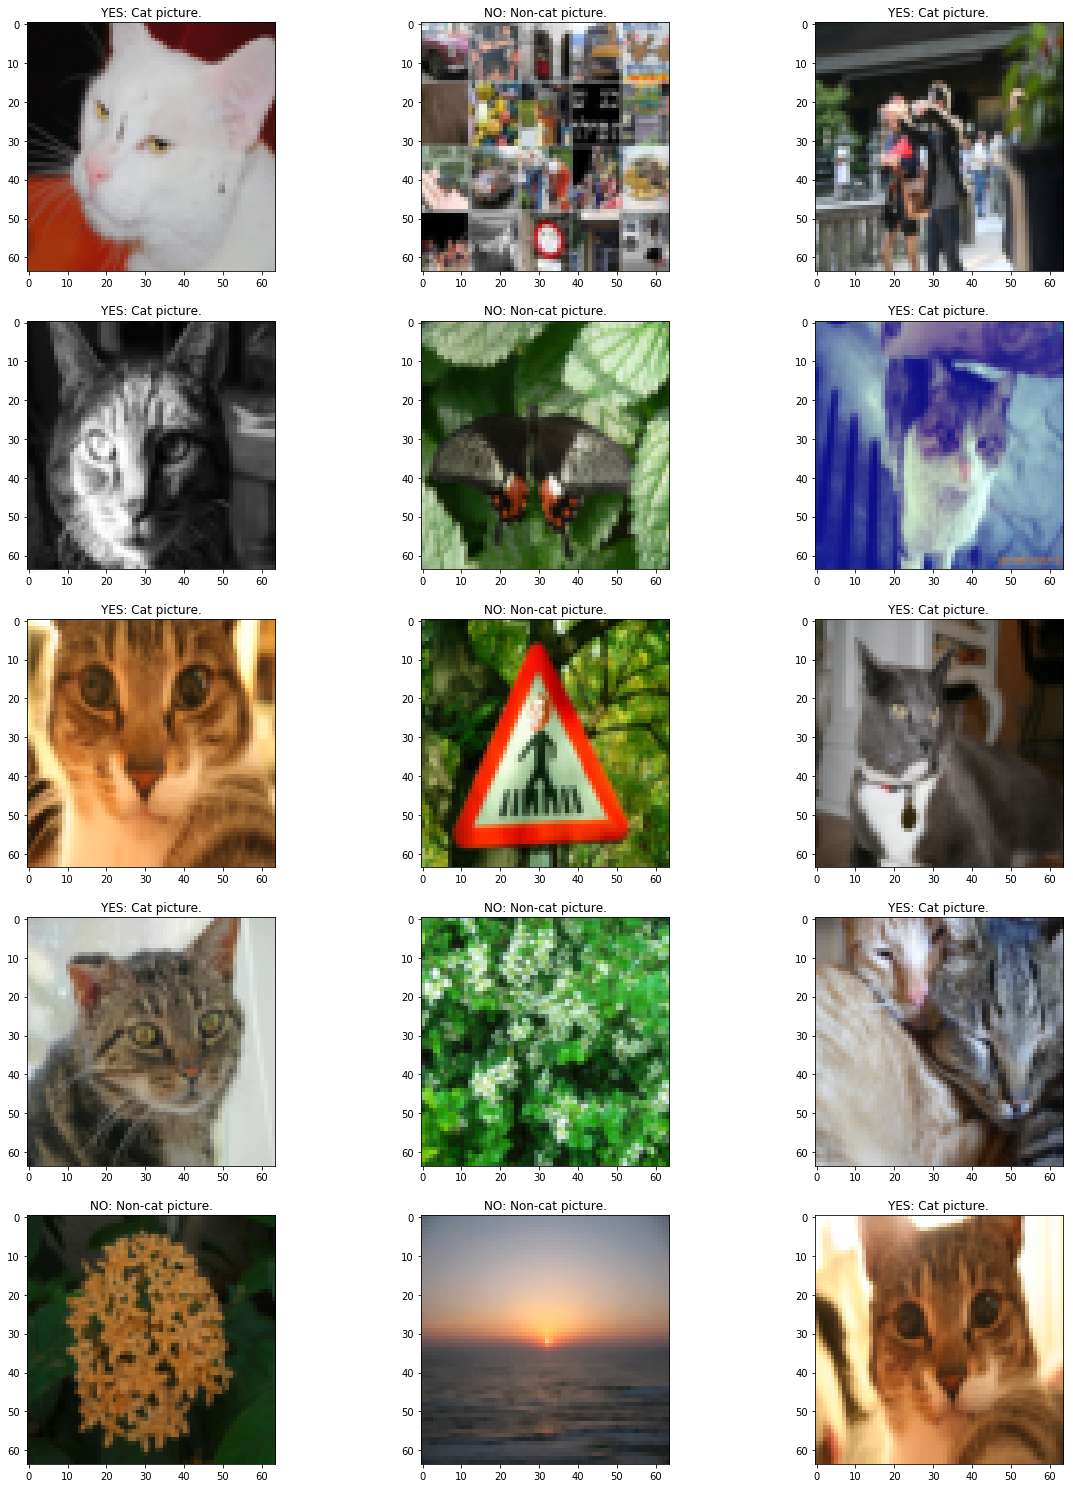

In [25]:
print("TESTING SET:")
try_decision(parameters, testing_imgLoaded, testing_label)